# Requirements

In [2]:
import pandas as pd
import numpy as np
import scipy
import pickle
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import sddk
import tempun

In [40]:
# global parameters for plots
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    #each figure to be saved in four different versions
    fig.savefig("../figures/" + fig_name + ".tiff")
    fig.savefig("../figures/" + fig_name + ".png")

# Import the dataset

In [3]:
LIRE = gpd.read_parquet("../data/large_files/LIRE_deities.parquet")
# alternatively, use GeoJSON - it is more memory consuming, but it has been tested
# LIRE = gpd.read_file("../data/large_files/LIRE_deities.geojson", driver="GeoJSON")

In [4]:
LIRE.shape

(136190, 115)

In [5]:
LIRE["asclepius"].sum()

210

In [6]:
LIRE[(LIRE["asclepius"]) & (LIRE["type_of_inscription_auto"] =="epitaph")]

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,city_pop_est,city_geometry,nearest_city_type,nearest_city_dist,type_of_inscription_auto,type_of_inscription_auto_prob,geometry,asclepius,apollo,jupiter
63964,EDCS-21100456,"CIL 11, 07584",Etruria / Regio VII,Etruria / Regio VII,Civitavecchia / Centumcellae / Blera,"['Civitavecchia', 'Centumcellae', 'Blera']",270,,[tituli sepulcrales],[tituli sepulcrales],...,1989.0,"[11.796814, 42.09118]",middle,0.005242,epitaph,1.00,POINT (11.79225 42.09375),True,False,False
73825,EDCS-28300277,"IPOstie-A, 00142 = ISIS 00178 = CCCA-03, 00445",Latium et Campania / Regio I,Latium et Campania / Regio I,Fiumicino / Portus,"['Fiumicino', 'Portus']",138,,"[mulieres, viri]",[],...,1559.0,"[12.266667, 41.779167]",middle,0.034716,epitaph,0.97,POINT (12.23395 41.76757),True,False,False
92537,EDCS-18100945,"CIL 06, 02231",Roma,Roma,Roma,Roma,400,,"[sacerdotes pagani, tituli sacri, tituli sepul...","[tituli sacri, tituli sepulcrales]",...,923313.0,"[12.485098, 41.892777]",big,0.002233,epitaph,0.96,POINT (12.48293 41.89332),True,False,False
99326,EDCS-14800719,"CIL 06, 12505 (p 3511)",Roma,Roma,Roma,Roma,200,,"[mulieres, tituli sepulcrales, viri]",[tituli sepulcrales],...,923313.0,"[12.485098, 41.892777]",big,0.002233,epitaph,1.00,POINT (12.48293 41.89332),True,False,False
101216,EDCS-00600441,"CIL 06, 17441 = ICUR-06, 17407",Roma,Roma,Roma,Roma,500,,"[inscriptiones christianae, mulieres, nomen si...","[inscriptiones christianae, tituli sepulcrales]",...,923313.0,"[12.485098, 41.892777]",big,0.002233,epitaph,1.00,POINT (12.48293 41.89332),True,False,False
112317,EDCS-38700949,"ICUR-01, 00549",Roma,Roma,Roma,Roma,400,,"[inscriptiones christianae, mulieres, nomen si...","[inscriptiones christianae, tituli sepulcrales]",...,923313.0,"[12.485098, 41.892777]",big,0.002233,epitaph,1.00,POINT (12.48293 41.89332),True,False,False
116921,EDCS-34800518,"ICUR-03, 07043b",Roma,Roma,Roma,Roma,500,,"[inscriptiones christianae, tituli sepulcrales...","[inscriptiones christianae, tituli sepulcrales]",...,923313.0,"[12.485098, 41.892777]",big,0.002233,epitaph,1.00,POINT (12.48293 41.89332),True,False,False
127677,EDCS-22200434,"CIL 10, 07604 = IFPK 00196 = SRD 00088 = Porra...",Sardinia,Sardinia,Casteddu / Cagliari / Carales,"['Casteddu', 'Cagliari', 'Carales']",230,,"[mulieres, sacerdotes pagani, tituli sacri, ti...","[tituli sacri, tituli sepulcrales]",...,1000.0,"[9.104227, 39.220021]",minor,0.009154,epitaph,0.64,POINT (9.11285 39.21695),True,False,False


In [7]:
print(list(LIRE.columns))

['EDCS-ID', 'publication', 'province', 'province_list', 'place', 'place_list', 'end_yr_list', 'notes_dating', 'status_list', 'inscr_type', 'status_notation', 'inscr_process', 'notes_references', 'notes_comments', 'inscription', 'inscription_stripped_final', 'Links', 'dating from', 'dating to', 'status', 'Latitude', 'Longitude', 'photo', 'Material', 'Comment', 'EDH-ID', 'language_EDCS', 'clean_text_interpretive_word_EDCS', 'responsible_individual', 'type_of_inscription', 'letter_size', 'literature', 'work_status', 'height', 'diplomatic_text', 'people', 'depth', 'material', 'type_of_monument', 'province_label', 'width', 'transcription', 'country', 'uri', 'findspot_ancient', 'last_update', 'modern_region', 'findspot_modern', 'edh_geography_uri', 'commentary', 'trismegistos_uri', 'external_image_uris', 'fotos', 'idno_tm', 'placenames_refs', 'text_edition', 'origdate_text', 'layout_execution', 'layout_execution_text', 'support_objecttype', 'support_objecttype_text', 'support_material', 'sup

# Static explorations of the dataset


In [19]:
deities_inscr_types = [dict(LIRE[LIRE["asclepius"]].groupby("type_of_inscription_auto").size()),
                       dict(LIRE[LIRE["apollo"]].groupby("type_of_inscription_auto").size()),
                       dict(LIRE[LIRE["jupiter"]].groupby("type_of_inscription_auto").size()),
                      dict(LIRE.groupby("type_of_inscription_auto").size())]

In [20]:
deities_inscr_types[0]

{'building/dedicatory inscription': 10,
 'defixio': 1,
 'epitaph': 8,
 'honorific inscription': 2,
 'votive inscription': 176}

In [21]:
deities_inscr_types_df = pd.DataFrame(deities_inscr_types)
deities_inscr_types_df.fillna(0, inplace=True)
deities_inscr_types_df = deities_inscr_types_df.astype(int)
deities_inscr_types_df.index = ["asclepius", "apollo", "jupiter", "LIRE_all"]
deities_inscr_types_df = deities_inscr_types_df.T
deities_inscr_types_df.sort_values("asclepius", ascending=False, inplace=True)
deities_inscr_types_df

,asclepius,apollo,jupiter,LIRE_all
votive inscription,176,343,2743,15700
building/dedicatory inscription,10,11,47,3241
epitaph,8,44,3,74578
honorific inscription,2,12,6,5573
defixio,1,0,1,292
assignation inscription,0,0,0,16
private legal inscription,0,0,0,37
prayer,0,0,0,23
letter,0,0,0,288
identification inscription,0,0,0,1910


In [22]:
deities_inscr_types_df["asclepius_pct"] = np.round((deities_inscr_types_df["asclepius"] / deities_inscr_types_df["asclepius"].sum()) / 0.01, 2)
deities_inscr_types_df["apollo_pct"] = np.round((deities_inscr_types_df["apollo"] / deities_inscr_types_df["apollo"].sum()) / 0.01, 2)
deities_inscr_types_df["jupiter_pct"] = np.round((deities_inscr_types_df["jupiter"] / deities_inscr_types_df["jupiter"].sum()) / 0.01, 2)
deities_inscr_types_df["LIRE_all_pct"] = np.round((deities_inscr_types_df["LIRE_all"] / deities_inscr_types_df["LIRE_all"].sum()) / 0.01, 2)

In [23]:
new_col_names = []
for col in deities_inscr_types_df.columns:
    try:
        N_value = LIRE[col.partition("_")[0]].sum()
    except:
        N_value = len(LIRE)
    new_col = col + " (N={})".format(N_value)
    new_col_names.append(new_col)
new_col_names

['asclepius (N=210)',
 'apollo (N=474)',
 'jupiter (N=2855)',
 'LIRE_all (N=136190)',
 'asclepius_pct (N=210)',
 'apollo_pct (N=474)',
 'jupiter_pct (N=2855)',
 'LIRE_all_pct (N=136190)']

In [24]:
deities_inscr_types_df.columns = new_col_names
deities_inscr_types_df

,asclepius (N=210),apollo (N=474),jupiter (N=2855),LIRE_all (N=136190),asclepius_pct (N=210),apollo_pct (N=474),jupiter_pct (N=2855),LIRE_all_pct (N=136190)
votive inscription,176,343,2743,15700,89.34,81.28,97.75,13.45
building/dedicatory inscription,10,11,47,3241,5.08,2.61,1.67,2.78
epitaph,8,44,3,74578,4.06,10.43,0.11,63.88
honorific inscription,2,12,6,5573,1.02,2.84,0.21,4.77
defixio,1,0,1,292,0.51,0.00,0.04,0.25
assignation inscription,0,0,0,16,0.00,0.00,0.00,0.01
private legal inscription,0,0,0,37,0.00,0.00,0.00,0.03
prayer,0,0,0,23,0.00,0.00,0.00,0.02
letter,0,0,0,288,0.00,0.00,0.00,0.25
identification inscription,0,0,0,1910,0.00,0.00,0.00,1.64


In [25]:
rest_sum_df = pd.DataFrame(deities_inscr_types_df[deities_inscr_types_df["asclepius (N=210)"]==0].sum()).T
rest_sum_df.index = ["rest"]
rest_sum_df

,asclepius (N=210),apollo (N=474),jupiter (N=2855),LIRE_all (N=136190),asclepius_pct (N=210),apollo_pct (N=474),jupiter_pct (N=2855),LIRE_all_pct (N=136190)
rest,0.0,12.0,6.0,17369.0,0.0,2.84,0.24,14.87


In [26]:
deities_inscr_types_reduced_df = pd.concat([
    deities_inscr_types_df[deities_inscr_types_df["asclepius (N=210)"]!=0],
    rest_sum_df
])
deities_inscr_types_reduced_df

,asclepius (N=210),apollo (N=474),jupiter (N=2855),LIRE_all (N=136190),asclepius_pct (N=210),apollo_pct (N=474),jupiter_pct (N=2855),LIRE_all_pct (N=136190)
votive inscription,176.0,343.0,2743.0,15700.0,89.34,81.28,97.75,13.45
building/dedicatory inscription,10.0,11.0,47.0,3241.0,5.08,2.61,1.67,2.78
epitaph,8.0,44.0,3.0,74578.0,4.06,10.43,0.11,63.88
honorific inscription,2.0,12.0,6.0,5573.0,1.02,2.84,0.21,4.77
defixio,1.0,0.0,1.0,292.0,0.51,0.00,0.04,0.25
rest,0.0,12.0,6.0,17369.0,0.00,2.84,0.24,14.87


In [27]:
deities_inscr_types_reduced_df.columns

Index(['asclepius (N=210)', 'apollo (N=474)', 'jupiter (N=2855)',
       'LIRE_all (N=136190)', 'asclepius_pct (N=210)', 'apollo_pct (N=474)',
       'jupiter_pct (N=2855)', 'LIRE_all_pct (N=136190)'],
      dtype='object')

In [33]:
df = deities_inscr_types_reduced_df[['asclepius_pct (N=210)', 'apollo_pct (N=474)', 'jupiter_pct (N=2855)', 'LIRE_all_pct (N=136190)']]
df

,asclepius_pct (N=210),apollo_pct (N=474),jupiter_pct (N=2855),LIRE_all_pct (N=136190)
votive inscription,89.34,81.28,97.75,13.45
building/dedicatory inscription,5.08,2.61,1.67,2.78
epitaph,4.06,10.43,0.11,63.88
honorific inscription,1.02,2.84,0.21,4.77
defixio,0.51,0.00,0.04,0.25
rest,0.00,2.84,0.24,14.87


In [34]:
df.to_csv("../data/deities_pct_per_inscrtype.csv")

# Exploring durations

In [35]:
def get_duration(start, stop):
  try:
    duration = abs(int(start) - int(stop)) + 1
    if 0 in range(int(start),  int(stop)):
      duration = duration - 1
  except:
    duration = np.nan
  return duration

LIRE["duration"] = LIRE.apply(lambda row: get_duration(row["not_before"], row["not_after"]), axis=1)

In [37]:
1063 / 300

3.5433333333333334

Text(0.5, 1.0, 'Asclepius (N=210)')

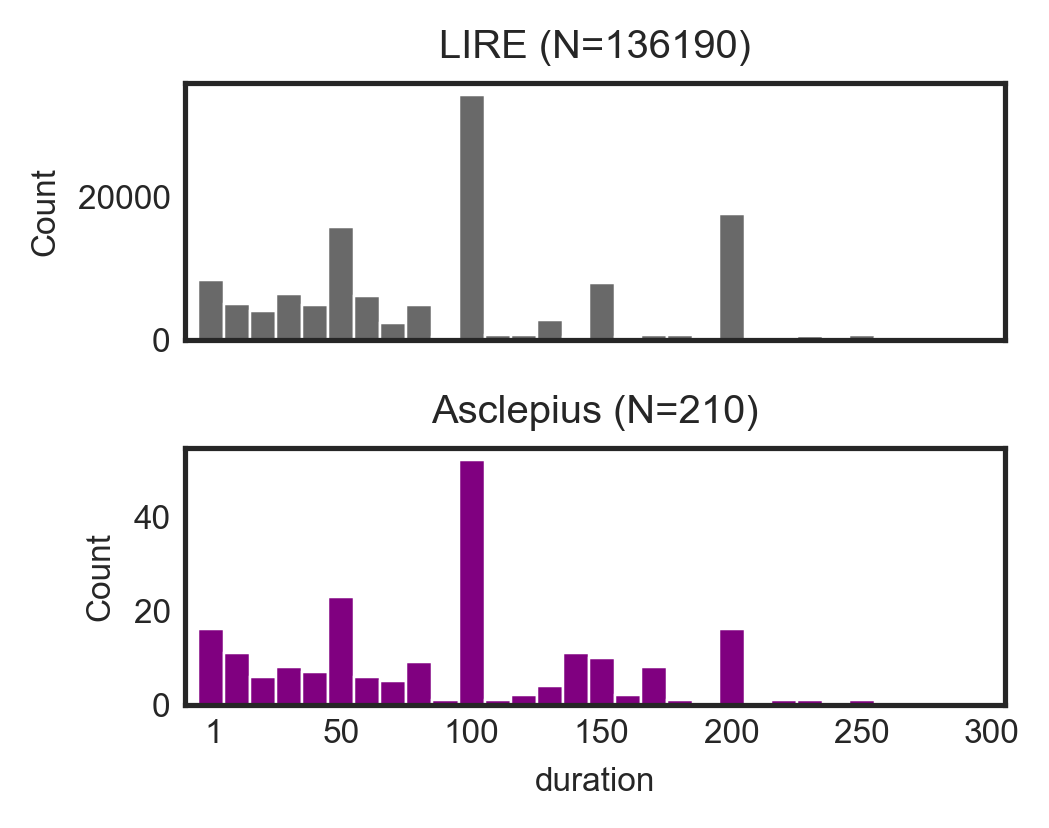

In [131]:
fig, [ax1,ax2] = plt.subplots(2,1, figsize=(3.54, 2.8), tight_layout=True)
sns.histplot(LIRE["duration"], kde=False, bins=range(-5, 305,10), alpha=1, color="dimgrey", ax=ax1)
ax1.set_xlim(-10, 305)
ax1.set_xlabel("")
ax1.set_xticklabels([])
ax1.set_title("LIRE (N={0})".format(str(len(LIRE))))
sns.histplot(LIRE[LIRE["asclepius"]]["duration"], kde=False, bins=range(-5, 305,10), alpha=1, color="purple", ax=ax2)
ax2.set_xlim(-10, 305)
ax2.set_xticks([1,50,100,150,200,250,300])
ax2.set_title("Asclepius (N={0})".format(str(len(LIRE[LIRE["asclepius"]]))))


In [132]:
save_figure(fig, "durations_lire+asclep")

In [156]:
np.round(len(LIRE[LIRE["duration"]<=10]) / len(LIRE) * 100, 2)

8.52

In [159]:
np.round(len(LIRE[(LIRE["asclepius"]) & (LIRE["duration"]<=10)]) / len(LIRE[LIRE["asclepius"]]) * 100, 2)

10.95

In [160]:
len(LIRE[(LIRE["asclepius"]) & (LIRE["duration"]<=10)])

23

In [161]:
LIRE["duration"].describe()

count    132909.000000
mean        103.449473
std          78.527142
min           1.000000
25%          50.000000
50%         100.000000
75%         150.000000
max        1909.000000
Name: duration, dtype: float64

In [165]:
len(LIRE[LIRE["asclepius"]])

210

In [163]:
LIRE[LIRE["asclepius"]]["duration"].describe()

count    205.000000
mean      93.790244
std       64.702259
min        1.000000
25%       50.000000
50%      100.000000
75%      144.000000
max      300.000000
Name: duration, dtype: float64

# Random dates and overall simulations

In [61]:
%%time
# generate a list of 1000 random dates for each inscription in the dataset
# takes approx. 90 seconds in Google colab
LIRE["random_dates"] = LIRE.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=1000,), axis=1)

CPU times: user 39.8 s, sys: 1.65 s, total: 41.4 s
Wall time: 42.3 s


In [62]:
%%time
LIRE_complete_simulations = tempun.timeblocks_from_randoms(LIRE, "random_dates", [-50, 350, 50])

CPU times: user 6.22 s, sys: 601 ms, total: 6.82 s
Wall time: 7.22 s


In [63]:
LIRE_complete_simulations[0]

[((-50, -1), 5228),
 ((1, 50), 20246),
 ((51, 100), 20053),
 ((101, 150), 22200),
 ((151, 200), 22148),
 ((201, 250), 17937),
 ((251, 300), 9504),
 ((301, 350), 8019)]

In [64]:
LIRE_complete_merged = tempun.simulations_merged(LIRE_complete_simulations)

In [65]:
len(LIRE_complete_merged)

8

In [66]:
print(LIRE_complete_merged[0][:50])

((-50, -1), [5228, 5249, 5221, 5199, 5221, 5198, 5229, 5291, 5230, 5255, 5263, 5280, 5198, 5278, 5215, 5229, 5247, 5241, 5265, 5226, 5221, 5255, 5173, 5241, 5163, 5305, 5230, 5249, 5220, 5284, 5233, 5220, 5142, 5210, 5209, 5263, 5322, 5206, 5212, 5185, 5350, 5294, 5255, 5265, 5227, 5251, 5289, 5183, 5228, 5273, 5281, 5224, 5177, 5256, 5232, 5220, 5165, 5268, 5184, 5220, 5223, 5253, 5164, 5209, 5341, 5302, 5206, 5250, 5288, 5304, 5205, 5271, 5178, 5254, 5236, 5207, 5230, 5225, 5207, 5250, 5210, 5246, 5245, 5268, 5240, 5210, 5270, 5243, 5156, 5245, 5276, 5225, 5210, 5154, 5263, 5222, 5215, 5253, 5253, 5267])


In [67]:
# periods definitions

periods = { # to avoid overlaps, startdates are postponed by one year, when needed
    "Julio-Claudian" : {"startdate": -27, "enddate" : 68},
    "Flavian" : {"startdate": 69, "enddate": 96},
    "Nerva-Antonine" : {"startdate" : 97, "enddate" : 192},
    "Severan" : {"startdate": 193, "enddate": 235},
    "Barracks emperors" : {"startdate" : 236, "enddate" : 284},
    "Tetrarchy\n& Constantine I" : {"startdate" : 285, "enddate" : 337}
    }
timeblocks_periods = [(periods[period]["startdate"], periods[period]["enddate"]) for period in periods]
timeblocks_periods

[(-27, 68), (69, 96), (97, 192), (193, 235), (236, 284), (285, 337)]

In [68]:
colors_list = [color for color in list(mcolors.CSS4_COLORS.keys()) if "light" in color][2:]
colors_list

['lightcyan',
 'lightgoldenrodyellow',
 'lightgray',
 'lightgreen',
 'lightgrey',
 'lightpink',
 'lightsalmon',
 'lightseagreen',
 'lightskyblue',
 'lightslategray',
 'lightslategrey',
 'lightsteelblue',
 'lightyellow']

In [69]:
periods_duration = [abs(tup[1] - tup[0]) for tup in timeblocks_periods]
periods_duration

[95, 27, 95, 42, 48, 52]

In [70]:
%%time
var_data = []
for var_n in range(1000):
    var_data.append([var[var_n] for var in LIRE["random_dates"] if var !=None])

CPU times: user 42.9 s, sys: 5.87 s, total: 48.8 s
Wall time: 52.6 s


# Deities over time

In [71]:
type_dict = dict(LIRE[LIRE["asclepius"]].groupby("type_of_inscription_auto", dropna=False).size()) 
type_dict

{'building/dedicatory inscription': 10,
 'defixio': 1,
 'epitaph': 8,
 'honorific inscription': 2,
 'votive inscription': 176,
 nan: 13}

In [72]:
def get_vars_FAST(df_whole, deity):
    df_part = df_whole[df_whole[deity]]
    df_sample = pd.DataFrame()
    type_dict = dict(df_part.groupby("type_of_inscription_auto", dropna=False).size()) # groups, including Nones
    for key in type_dict.keys():
        if isinstance(key, float): # if nan
            df_type = df_whole[df_whole["type_of_inscription_auto"].isnull()].sample(type_dict[key])
        else:
            df_type = df_whole[df_whole["type_of_inscription_auto"]==key].sample(type_dict[key])
        df_sample = pd.concat([df_sample, df_type])
    var_data_deity, var_data_deity_control, tb_data, tb_data_control = [], [], [], [] 
    timeblocks = tempun.get_timeblocks(-50, 350, 25)
    for var_n in range(1000):
        var_data = [var[var_n] for var in df_part["random_dates"] if var !=None]
        var_data_deity.append(var_data)
        tb_var_data = tempun.dates_per_block(var_data, timeblocks)
        tb_data.append(tb_var_data)
        var_data_control = [var[var_n] for var in df_sample["random_dates"] if var !=None]
        var_data_deity_control.append(var_data_control)
        tb_var_data_control = tempun.dates_per_block(var_data_control, timeblocks)
        tb_data_control.append(tb_var_data_control)
    return var_data_deity, var_data_deity_control, tb_data, tb_data_control

In [73]:
def get_vars(df_whole, deity):
    df_part = df_whole[df_whole[deity]]
    type_dict = dict(df_part.groupby("type_of_inscription_auto", dropna=False).size()) # groups, including Nones
    var_data_deity, var_data_deity_control, tb_data, tb_data_control = [], [], [], [] 
    timeblocks = tempun.get_timeblocks(-50, 350, 25)
    for var_n in range(1000):
        var_data = [var[var_n] for var in df_part["random_dates"] if var !=None]
        var_data_deity.append(var_data)
        tb_var_data = tempun.dates_per_block(var_data, timeblocks)
        tb_data.append(tb_var_data)
        df_sample = pd.DataFrame()
        for key in type_dict.keys():
            if isinstance(key, float): # if nan
                df_type = df_whole[df_whole["type_of_inscription_auto"].isnull()].sample(type_dict[key], random_state=var_n)
            else:
                df_type = df_whole[df_whole["type_of_inscription_auto"]==key].sample(type_dict[key], random_state=var_n)
            df_sample = pd.concat([df_sample, df_type])
        var_data_control = [var[var_n] for var in df_sample["random_dates"] if var !=None]
        var_data_deity_control.append(var_data_control)
        tb_var_data_control = tempun.dates_per_block(var_data_control, timeblocks)
        tb_data_control.append(tb_var_data_control)
    return var_data_deity, var_data_deity_control, tb_data, tb_data_control

In [74]:
%%time
var_data_asclep, var_data_asclep_control, tb_data_asclep, tb_data_asclep_control = get_vars(LIRE, "asclepius")
var_data_apollo, var_data_apollo_control, tb_data_apollo, tb_data_apollo_control = get_vars(LIRE, "apollo")
var_data_jupiter, var_data_jupiter_control, tb_data_jupiter, tb_data_jupiter_control = get_vars(LIRE, "jupiter")

CPU times: user 10min 37s, sys: 17.3 s, total: 10min 54s
Wall time: 10min 58s


In [75]:
asclep_temp_data = [var_data_asclep, var_data_asclep_control, tb_data_asclep, tb_data_asclep_control]

In [76]:
def pickle_data(data, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)

pickle_data([var_data_asclep, var_data_asclep_control, tb_data_asclep, tb_data_asclep_control], "../data/large_files/asclep_temp_data.pkl")
pickle_data([var_data_apollo, var_data_apollo_control, tb_data_apollo, tb_data_apollo_control], "../data/large_files/apollo_temp_data.pkl")
pickle_data([var_data_jupiter, var_data_jupiter_control, tb_data_jupiter, tb_data_jupiter_control], "../data/large_files/jupiter_temp_data.pkl")

In [283]:
### uncomment to read back previously generated and saved data

#data = pickle.load(open('../data/large_files/asclep_temp_data.pkl', 'rb'))
#var_data_asclep, var_data_asclep_control, tb_data_asclep, tb_data_asclep_control = data[0], data[1], data[2], data[3]

#data = pickle.load(open('../data/large_files/apollo_temp_data.pkl', 'rb'))
#var_data_apollo, var_data_apollo_control, tb_data_apollo, tb_data_apollo_control = data[0], data[1], data[2], data[3]

#data = pickle.load(open('../data/large_files/jupiter_temp_data.pkl', 'rb'))
#var_data_jupiter, var_data_jupiter_control, tb_data_jupiter, tb_data_jupiter_control = data[0], data[1], data[2], data[3]

In [77]:
print(len(var_data_asclep[0]))
print(len(var_data_apollo[0]))
print(len(var_data_jupiter[0]))

210
474
2855


In [78]:
print(len(var_data_asclep_control[0]))
print(len(var_data_apollo_control[0]))
print(len(var_data_jupiter_control[0]))

210
474
2855


CPU times: user 1min 52s, sys: 11.1 s, total: 2min 3s
Wall time: 2min 6s


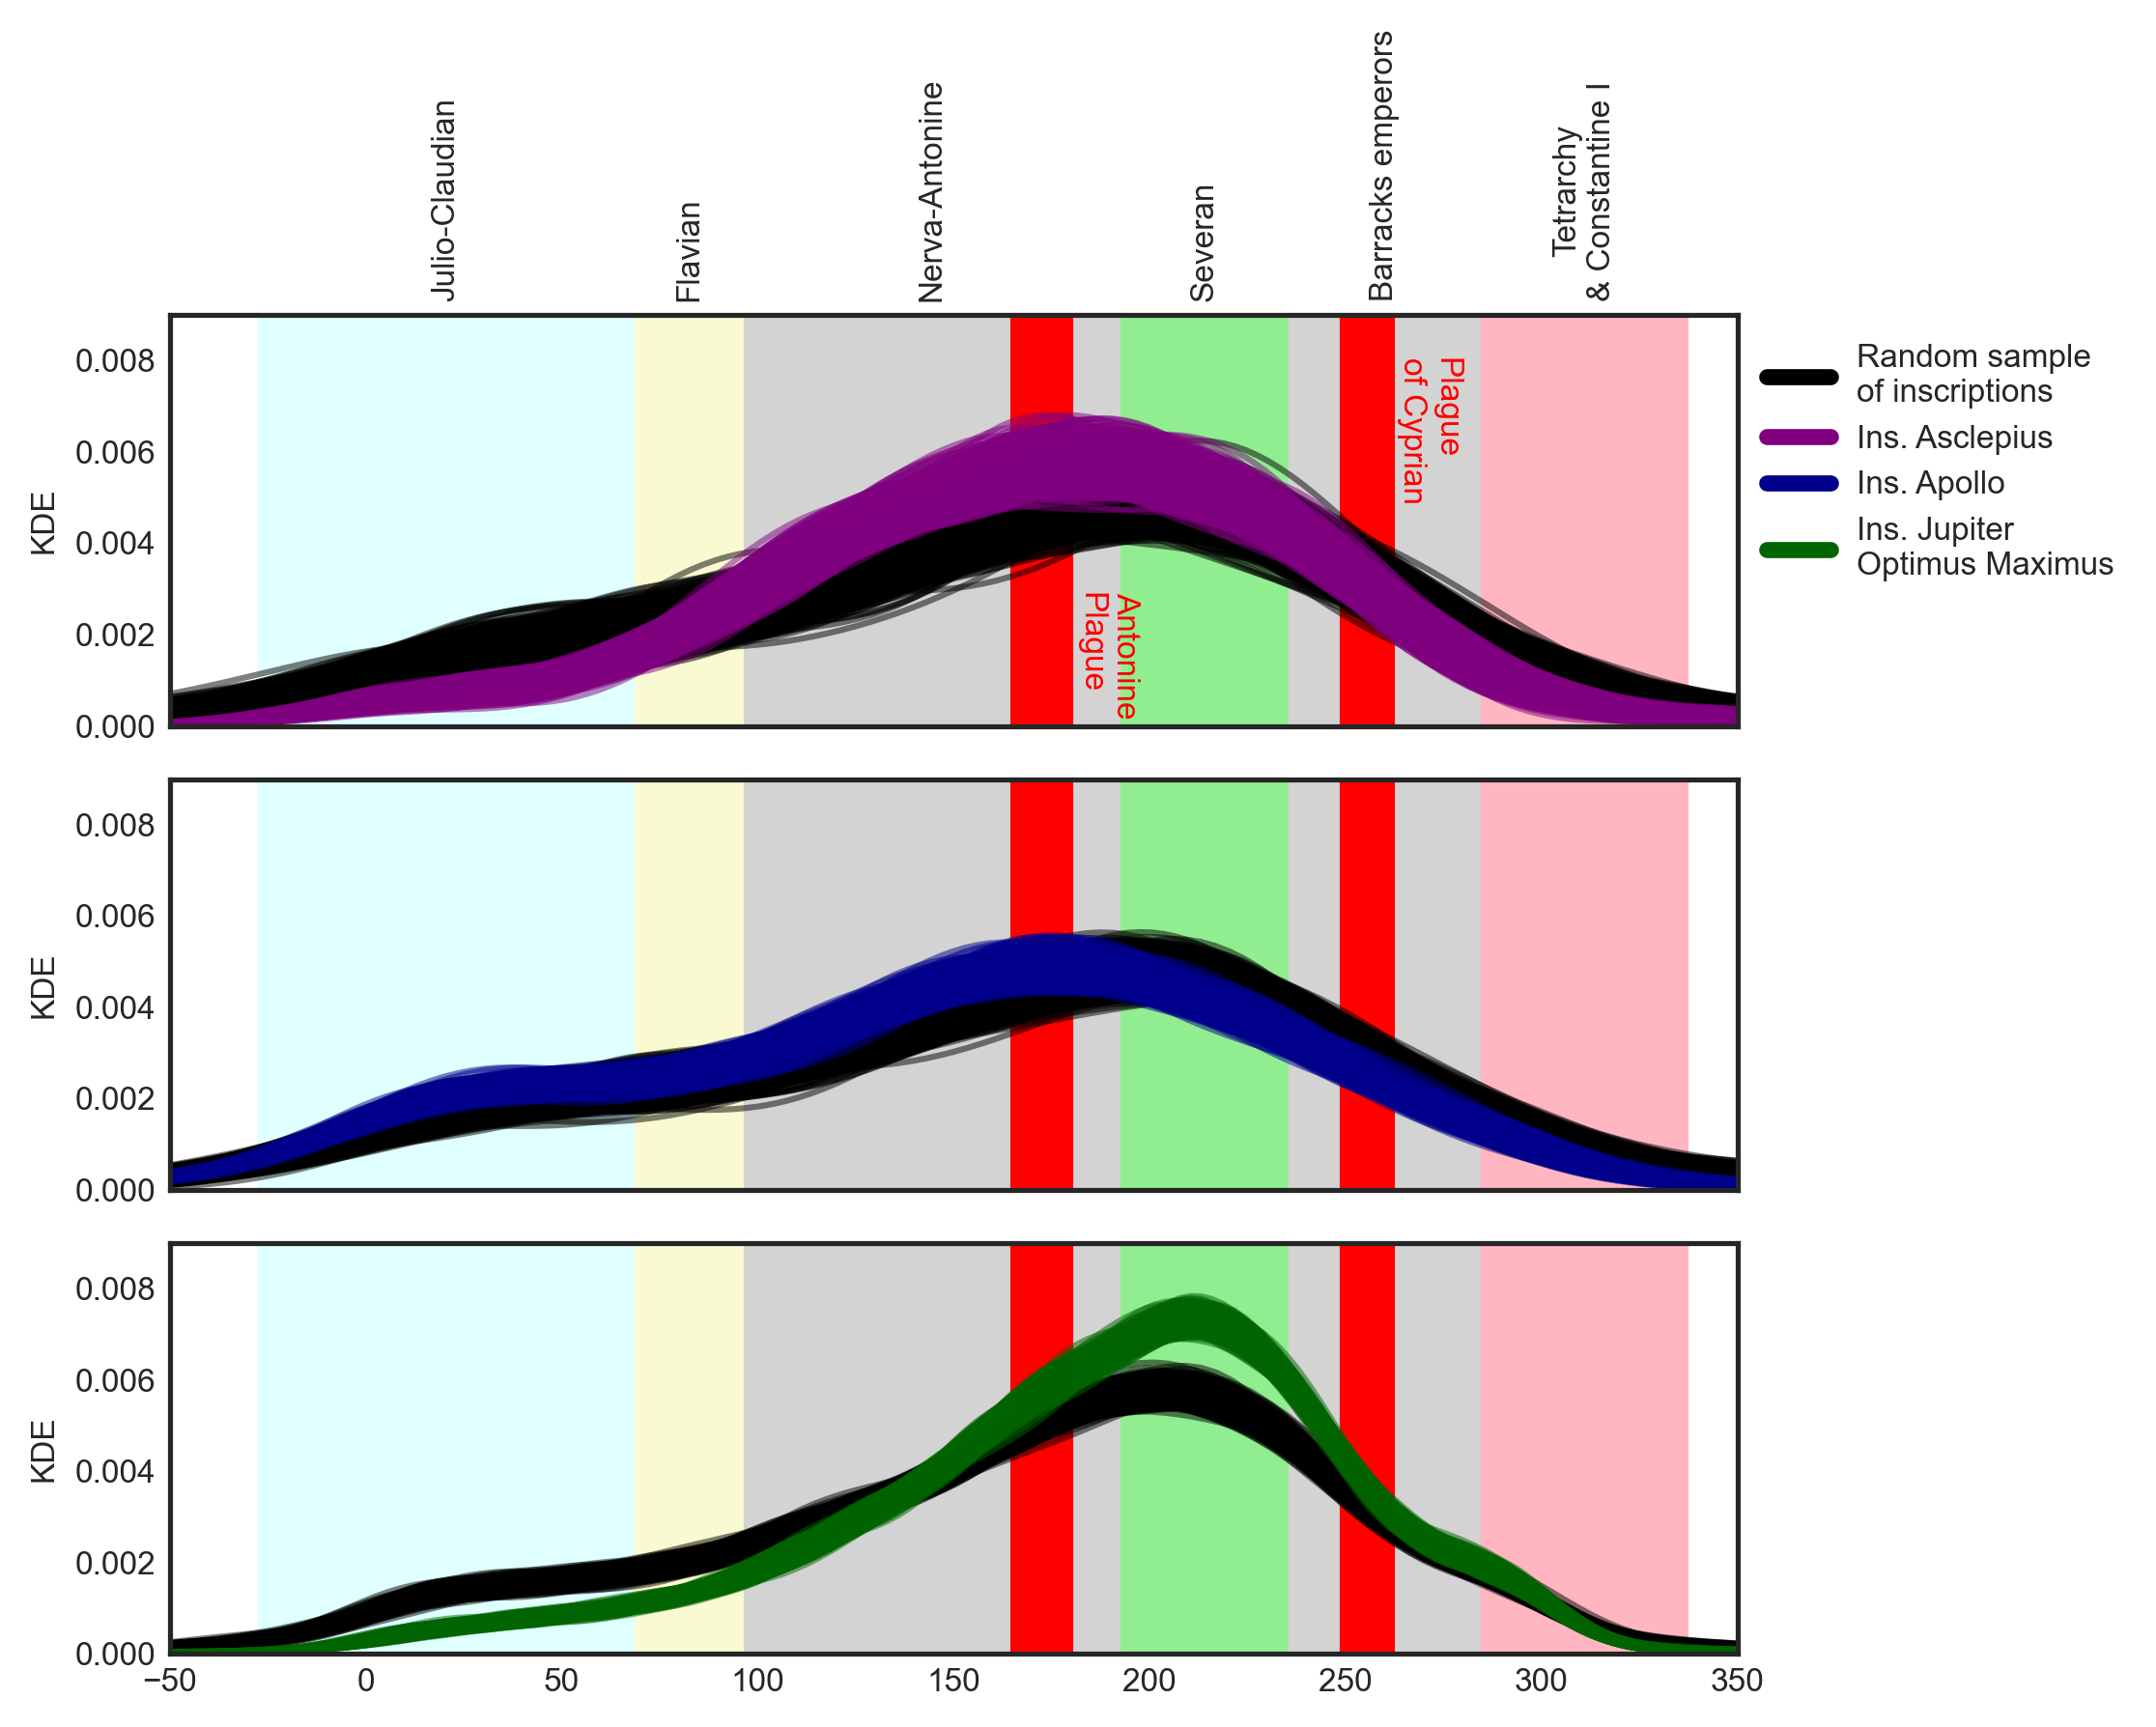

In [123]:
%%time
# timeconsuming, because of the KDE involved
n_sims = 1000
labels=[key for key in periods.keys()]
positions = [np.mean(tup) for tup in timeblocks_periods]

#positions = [np.mean(tup[0]) for tup in occups_ratios_merged]

fig, [ax1,ax2,ax3] = plt.subplots(3,1, figsize=[7.48, 6], tight_layout=True)

### ax1 - Asclepius
for period, color in zip(periods.keys(), colors_list):
    ax1.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)#, linestyles="dashed", color="red")
# period labels
ax1.set_xticks(positions)
ax1.set_xticklabels(labels)
ax1.xaxis.set_tick_params(rotation=90)
ax1.xaxis.tick_top()

for data in var_data_asclep_control[:n_sims]:
    sns.kdeplot(data, ax=ax1, color="black", alpha=0.5)
for data in var_data_asclep[:n_sims]:
    sns.kdeplot(data, ax=ax1, color="purple", alpha=0.5)

    ax1.set_xlim(-50,350)
ax1.set_ylabel("KDE")
ax1.set_ylim(0, 0.009)


ax1.axvspan(165, 180, color="red")
ax1.annotate("Antonine\nPlague", xy=(181,0.0003), xycoords='data', color="red", rotation=270, fontsize=8)


ax1.axvspan(249, 262, color="red")
ax1.annotate("Plague\nof Cyprian", xy=(263,0.005), xycoords='data', color="red", rotation=270, fontsize=8)

### ax2 - Apollo
for period, color in zip(periods.keys(), colors_list):
    ax2.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)#, linestyles="dashed", color="red")


for data in var_data_apollo_control[:n_sims]:
    sns.kdeplot(data, ax=ax2, color="black", alpha=0.5)
for data in var_data_apollo[:n_sims]:
    sns.kdeplot(data, ax=ax2, color="darkblue", alpha=0.5)
    
ax2.set_xlim(-50,350)
ax2.set_ylabel("KDE")
ax2.set_ylim(0, 0.009)
ax2.set_xticks([])

ax2.axvspan(165, 180, color="red")
ax2.axvspan(249, 262, color="red")

### ax3 - Jupyter
for period, color in zip(periods.keys(), colors_list):
    ax3.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)

for data in var_data_jupiter_control[:n_sims]:
    sns.kdeplot(data, ax=ax3, color="black", alpha=0.5)
for data in var_data_jupiter[:n_sims]:
    sns.kdeplot(data, ax=ax3, color="darkgreen", alpha=0.5)    
ax3.set_xlim(-50,350)
ax3.set_ylabel("KDE")
ax3.set_ylim(0, 0.009)

ax3.axvspan(165, 180, color="red")
ax3.axvspan(249, 262, color="red")

markers = [plt.Line2D([0,0],[0,0],color=color, lw=4) for color in ["black", "purple", "darkblue", "darkgreen"]]
ax1.legend(markers, ["Random sample\nof inscriptions", "Ins. Asclepius", "Ins. Apollo", "Ins. Jupiter\nOptimus Maximus"], bbox_to_anchor=(1, 1), loc='upper left')


In [124]:
save_figure(fig, "comparing_distributions_kde")

# Statistical comparison


We use two-sample Kolmogorov-Smirnov test, which checks whether  two data samples come from the same distribution. This does not specify what that common distribution is (e.g. whether it's normal or not normal).  

We employ it to compare distribution of all iscriptions mentioning the deity against a distribution based on a random sample of inscriptions of the same length and of the same proportion of inscription types. We repeat this procedure for all dating simulations and evaluate the consinstency of the findings.

In [81]:
# average p_value for two samples from the same distribution
avg_p = np.mean([scipy.stats.ks_2samp(var_data_asclep[int(np.random.random()*1000)], var_data_asclep[int(np.random.random()*1000)]).pvalue for n in range(1,1000)])
avg_p

0.8243331672319

In [83]:
# average KS_statistic p_value for two samples
p_values = np.mean([scipy.stats.ks_2samp(var_data_asclep[n], var_data_asclep_control[n]).pvalue for n in range(0,1000)])
KS_statistic = np.mean([scipy.stats.ks_2samp(var_data_asclep[n], var_data_asclep_control[n]).statistic for n in range(0,1000)])
print("KS_statistic={0}, p={1}".format(KS_statistic, p_values))

KS_statistic=0.11114761904761905, p=0.2179683530863155


In [84]:
def ks_per_samplesets(sampleset, sampleset_control, subsample_len=None):
    if subsample_len == None:
        subsample_len = len(sampleset[0])
    KS_statistic = np.round(np.mean([scipy.stats.ks_2samp(sampleset[n][:subsample_len], sampleset_control[n][:subsample_len]).statistic for n in range(0,1000)]), 4)
    p_values = np.round(np.mean([scipy.stats.ks_2samp(sampleset[n][:subsample_len], sampleset_control[n][:subsample_len]).pvalue for n in range(0,1000)]), 4)
    return KS_statistic, p_values

In [85]:
ks_per_samplesets(var_data_asclep, var_data_asclep_control)

(0.1111, 0.218)

In [86]:
ks_per_samplesets(var_data_apollo, var_data_apollo_control)

(0.1016, 0.0617)

In [87]:
ks_per_samplesets(var_data_apollo, var_data_apollo_control, 210)

(0.1064, 0.2695)

In [88]:
ks_per_samplesets(var_data_jupiter, var_data_jupiter_control)

(0.1104, 0.0)

In [89]:
ks_per_samplesets(var_data_jupiter, var_data_jupiter_control, 210)

(0.1883, 0.0078)

In [90]:
ks_per_samplesets(var_data_asclep, var_data_apollo, 210)

(0.0769, 0.5778)

In [91]:
ks_per_samplesets(var_data_asclep, var_data_jupiter, 210)

(0.1659, 0.0163)

In [92]:
ks_per_samplesets(var_data_apollo, var_data_jupiter, 210)

(0.1608, 0.0246)

# Comparing differences over timeblocks

In [93]:
tb_data_asclep_merged = tempun.simulations_merged(tb_data_asclep)
tb_data_asclep_control_merged = tempun.simulations_merged(tb_data_asclep_control)

In [94]:
len(tb_data_asclep_control_merged[13][1])

1000

In [95]:
def calc_diff(list1, list2):
    return np.array(list1) - np.array(list2)

diffs_lists = []
for tb_ind in range(len(tb_data_asclep_merged)):
    tb = tb_data_asclep_merged[tb_ind]
    tb_control = tb_data_asclep_control_merged[tb_ind]
    diff_array = calc_diff(tb[1], tb_control[1])
    diffs_lists.append(diff_array)
    print(tb_data_asclep_merged[tb_ind][0], np.mean(diff_array), np.std(diff_array))

(-50, -26) -1.572 1.238069464933208
(-25, -1) -1.218 1.6499927272566994
(1, 25) -4.72 3.2823162553294583
(26, 50) -5.592 3.3727638517986995
(51, 75) -4.028 3.629216995441303
(76, 100) -0.294 4.0061907093896565
(101, 125) 7.383 5.293232566211312
(126, 150) 6.16 5.618220358796902
(151, 175) 5.985 6.183427447621586
(176, 200) 4.326 6.352458106906334
(201, 225) -3.041 6.473431779203361
(226, 250) 4.577 5.848424659684008
(251, 275) -0.807 4.396106345392477
(276, 300) -5.259 3.5173738783359383
(301, 325) -0.979 1.6194316904395814
(326, 350) -0.47 1.4856311789943022


In [96]:
diffs_lists[0][:20]

array([-1,  0,  0,  0, -1, -3, -3,  0, -1, -2, -1, -1, -1, -2, -1, -2, -1,
       -1, -4, -3])

In [97]:
np.mean(diffs_lists[0])

-1.572

In [98]:
np.median(diffs_lists[0])

-1.0

In [99]:
tbs = tempun.get_timeblocks(-50, 350, 25)
print(tbs)

[(-50, -26), (-25, -1), (1, 25), (26, 50), (51, 75), (76, 100), (101, 125), (126, 150), (151, 175), (176, 200), (201, 225), (226, 250), (251, 275), (276, 300), (301, 325), (326, 350)]


In [100]:
tb_labels = []
for tb in tbs:
    if tb[1] < 0:
        tb_label = "{0}-{1} BCE".format(str(abs(tb[0])), str(abs(tb[1])))
    else:
        tb_label = "{0}-{1} CE".format(str(tb[0]), str(tb[1]))
    tb_labels.append(tb_label)
                    

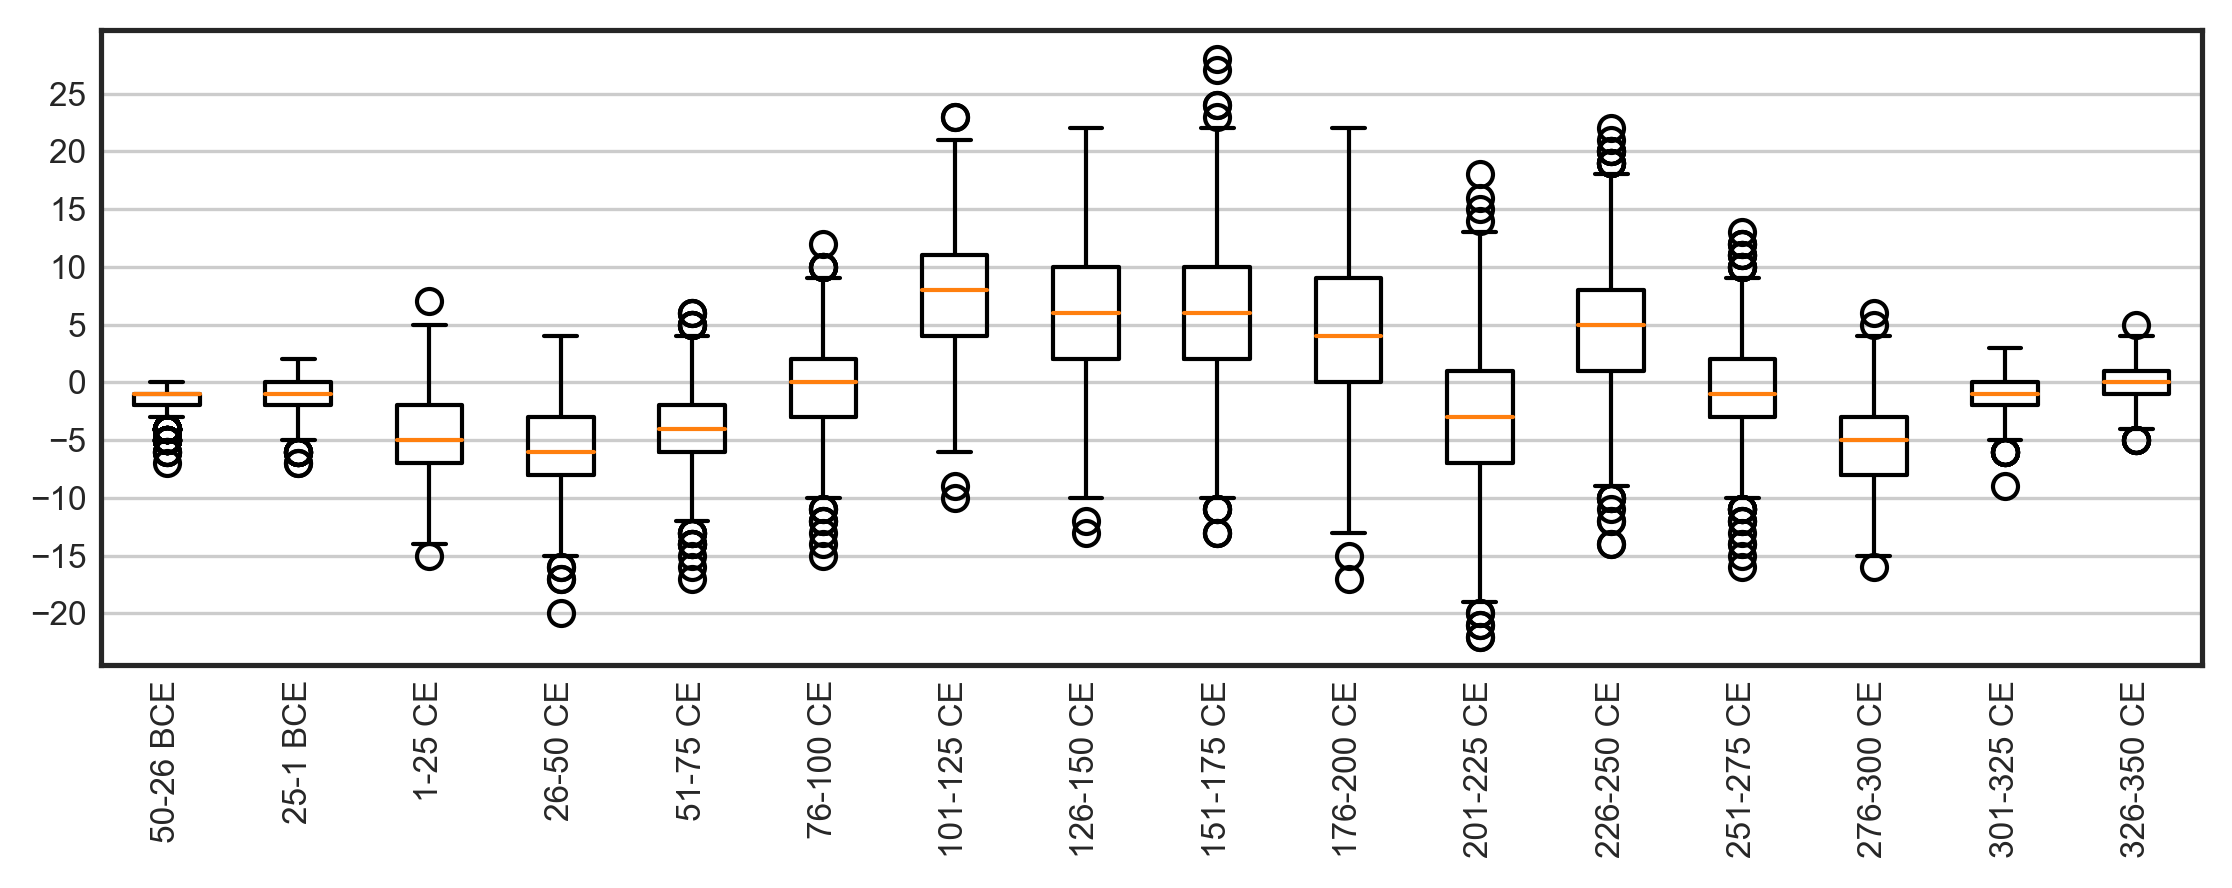

In [101]:
fig, ax = plt.subplots(figsize=(7.48, 3), tight_layout=True)
ax.boxplot(diffs_lists)
ax.set_xticklabels(tb_labels, rotation=90)
ax.set_yticks(range(-20, 30, 5))
ax.grid(axis="y")
plt.show()

In [186]:
def calc_diff_ratio(list1, list2):
    ratio_array = np.array(list1) / np.array(list2)
    ratio_array = np.nan_to_num(ratio_array, nan=0, posinf=0, neginf=0)
    return ratio_array

diffs_lists_ratio = []
for tb_ind in range(len(tb_data_asclep_merged)):
    tb = tb_data_asclep_merged[tb_ind]
    tb_control = tb_data_asclep_control_merged[tb_ind]
    diff_array = calc_diff_ratio(tb[1], tb_control[1])
    diffs_lists_ratio.append(diff_array)
    print(tb_data_asclep_merged[tb_ind][0], np.mean(diff_array), np.std(diff_array))

(-50, -26) 0.0 0.0
(-25, -1) 0.6581257936507936 0.5098219306407891
(1, 25) 0.5445571459929819 0.35451276204562676
(26, 50) 0.4316173743310353 0.2845498229630858
(51, 75) 0.6710086671369566 0.41806627171371186
(76, 100) 1.082689751742365 0.566912592792634
(101, 125) 1.5747488970998278 0.49838754932024387
(126, 150) 1.42007634402846 0.43781357988388836
(151, 175) 1.2946249386779076 0.3236370565183462
(176, 200) 1.1891853679951683 0.26703429269356854
(201, 225) 0.9246128415941895 0.22896939334552213
(226, 250) 1.249815413700326 0.3285802014887235
(251, 275) 1.030845797425268 0.5128046340157874
(276, 300) 0.5145690915852293 0.33445948747029525
(301, 325) 0.45813809523809523 0.6163424744266072
(326, 350) 0.41396666666666665 0.6159409594722173


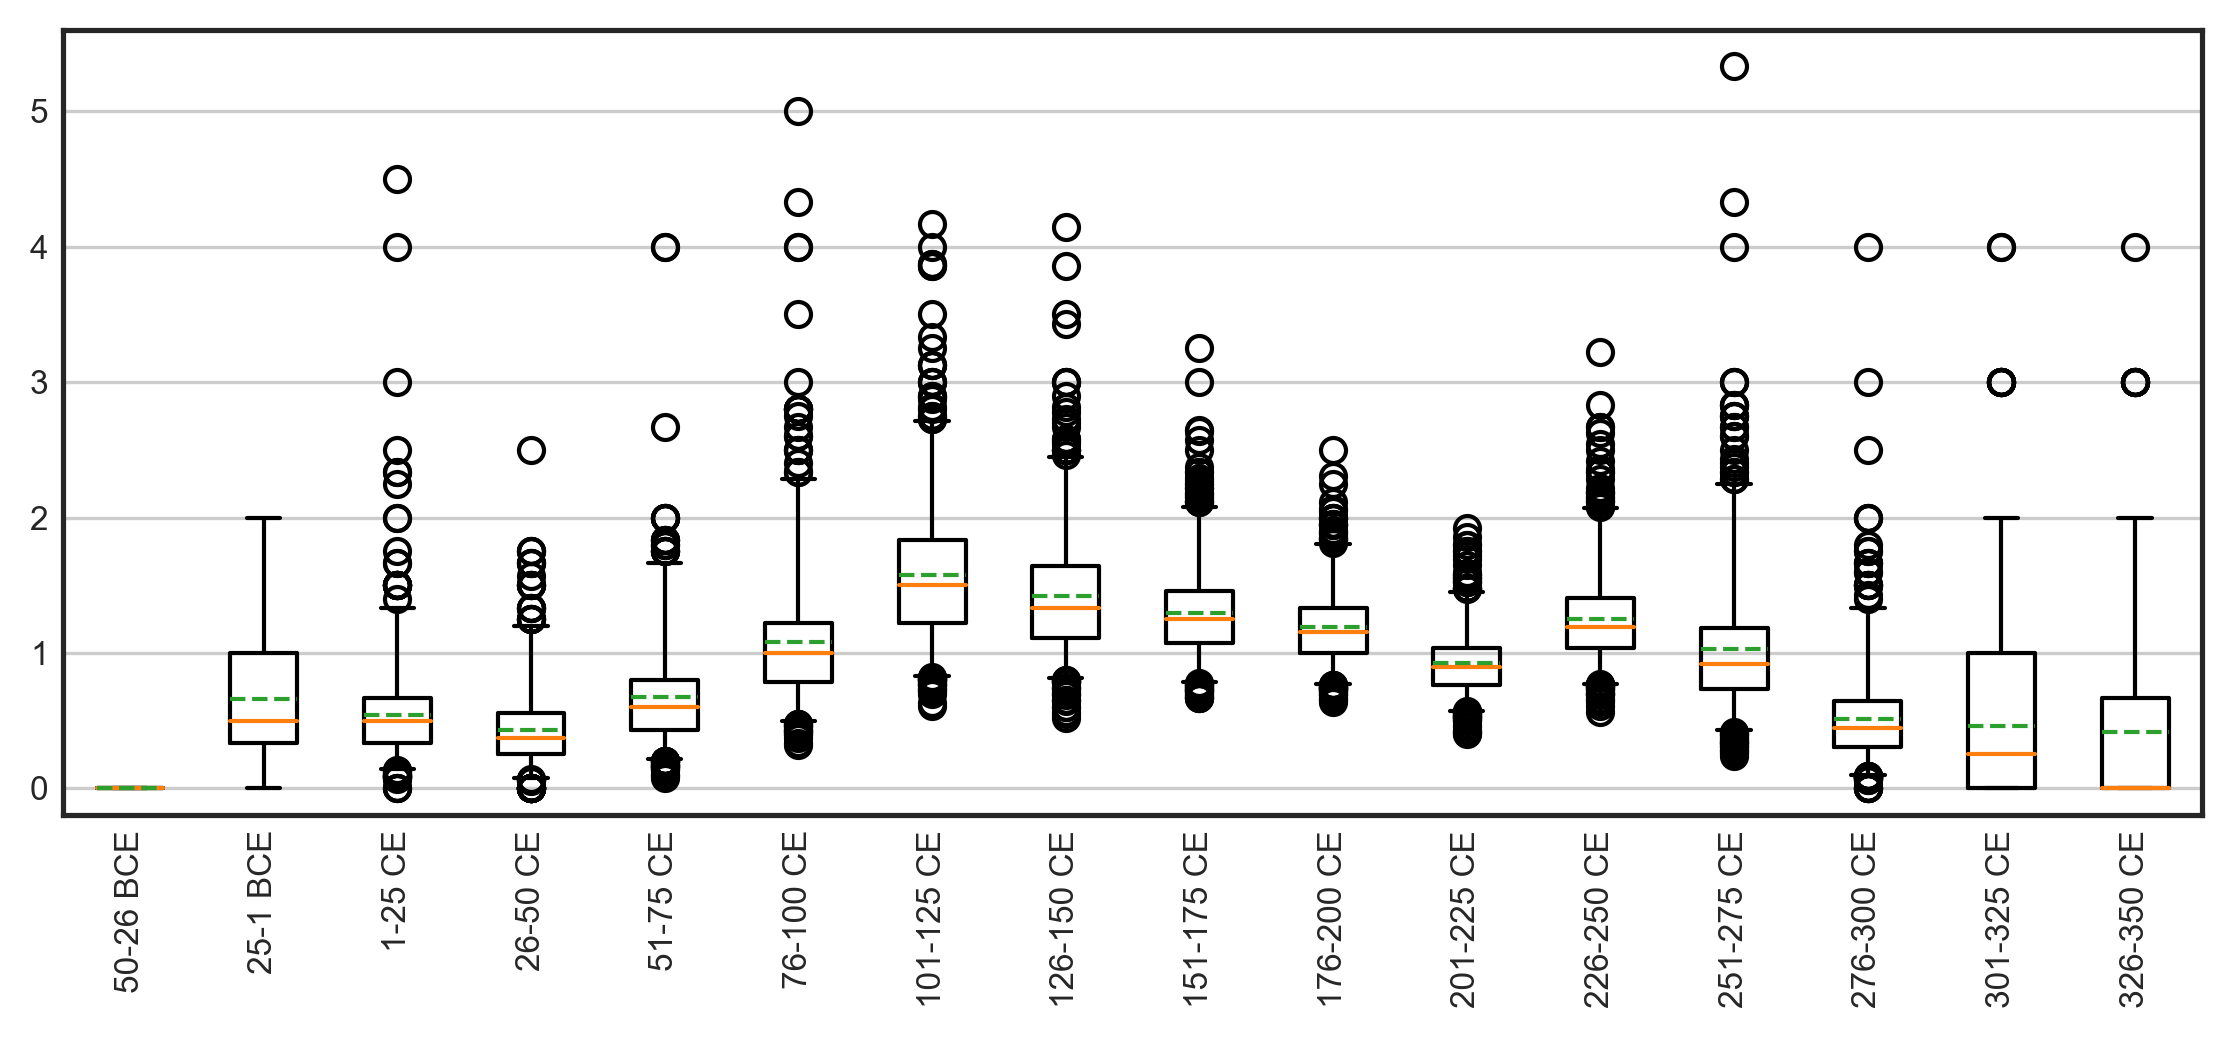

In [188]:
fig, ax = plt.subplots(figsize=(7.48, 3.5), tight_layout=True)
ax.boxplot(diffs_lists_ratio, showmeans=True, meanline=True, whis=[2.5, 97.5])
ax.set_xticklabels(tb_labels, rotation=90)
ax.set_ylim([-0.2, 5.6])
#ax.set_yticks(range(0, 30, 5))
ax.grid(axis="y")
plt.show()

In [189]:
save_figure(fig, "ratios_per_tbs")

In [112]:
max(diffs_lists_ratio[2])

4.5

In [352]:
pd.Series(diffs_lists_ratio[2]).describe()

count    1000.000000
mean        0.742717
std         0.486740
min         0.000000
25%         0.428571
50%         0.666667
75%         0.875000
max         5.000000
dtype: float64

In [353]:
np.median(diffs_lists_ratio[2])

0.6666666666666666